# Dataset Test: All Sources + Packed Streaming

Tests FineWeb-Edu (text) and conversation data (SmolTalk, UltraChat) using the unified `PackedStreamingDataset` from `run_10_midtrain.py`.

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from transformers import AutoTokenizer

# Setup tokenizer with special tokens (matches run_10_midtrain.py)
tokenizer = AutoTokenizer.from_pretrained('gpt2')
special_tokens = {
    'bos_token': '<|beginoftext|>',
    'pad_token': '<|pad|>',
    'additional_special_tokens': ['<|user|>', '<|assistant|>', '<|system|>']
}
tokenizer.add_special_tokens(special_tokens)
print(f'Vocab: {len(tokenizer)}')
print(f'BOS={tokenizer.bos_token_id}, EOS={tokenizer.eos_token_id}, PAD={tokenizer.pad_token_id}')

/home/zaccosenza/code/project-llm-chat/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vocab: 50262
BOS=50257, EOS=50256, PAD=50258


## 1. Data inventory

In [2]:
BASE_DIR = os.path.join(os.getcwd(), '..', 'data')
fineweb_dir = os.path.join(BASE_DIR, 'base_data')
conv_dir = os.path.join(BASE_DIR, 'conversation_data')

fineweb_files = sorted(f for f in os.listdir(fineweb_dir) if f.endswith('.parquet'))
conv_files = sorted(f for f in os.listdir(conv_dir) if f.endswith('.parquet'))

print(f'FineWeb-Edu:     {len(fineweb_files)} shards in {fineweb_dir}')
print(f'Conversation:    {len(conv_files)} shards in {conv_dir}')

# Quick schema check
fw_sample = pq.read_table(os.path.join(fineweb_dir, fineweb_files[0]), columns=None).schema
cv_sample = pq.read_table(os.path.join(conv_dir, conv_files[0]), columns=None).schema
print(f'\nFineWeb schema:  {fw_sample}')
print(f'Conv schema:     {cv_sample}')

FineWeb-Edu:     1706 shards in /home/zaccosenza/code/project-llm-chat/notebooks/../data/base_data
Conversation:    31 shards in /home/zaccosenza/code/project-llm-chat/notebooks/../data/conversation_data

FineWeb schema:  text: string
Conv schema:     messages: list<element: struct<content: string, role: string>>
  child 0, element: struct<content: string, role: string>
      child 0, content: string
      child 1, role: string
source: string
-- schema metadata --
huggingface: '{"info": {"features": {"messages": {"feature": {"content": ' + 155


## 2. FineWeb-Edu: sample & token lengths

In [3]:
# Read first shard (val shard) for FineWeb analysis
fw_table = pq.read_table(os.path.join(fineweb_dir, fineweb_files[0]))
fw_texts = fw_table['text'].to_pylist()
print(f'FineWeb val shard: {len(fw_texts)} documents')
print(f'\nExample (first 300 chars):\n{fw_texts[0][:300]}...')

FineWeb val shard: 53248 documents

Example (first 300 chars):
Shipment & Transport-Sea, Air, Rail, Road, Pipeline
The mode of transportation is an important consideration when planning the shipment process. Besides the costs, the urgency of the shipment, the value of the goods being shipped as well as the size and weight of the goods need to be evaluated when ...


In [4]:
# Token lengths for FineWeb docs
fw_token_counts = [len(tokenizer.encode(t, add_special_tokens=False)) for t in fw_texts[:5000]]
fw_arr = np.array(fw_token_counts)

print(f'FineWeb token lengths (n={len(fw_arr)}):')
print(f'  mean={fw_arr.mean():.0f}, median={np.median(fw_arr):.0f}, p95={np.percentile(fw_arr, 95):.0f}, max={fw_arr.max()}')
print(f'  >2048: {(fw_arr > 2048).sum()} ({(fw_arr > 2048).mean()*100:.1f}%)')

Token indices sequence length is longer than the specified maximum sequence length for this model (1820 > 1024). Running this sequence through the model will result in indexing errors


FineWeb token lengths (n=5000):
  mean=1017, median=620, p95=3058, max=51731
  >2048: 446 (8.9%)


## 3. Conversation data: source distribution & token lengths

In [5]:
import random
random.seed(42)

# Load all conversation rows
all_conv_rows = []
for f in conv_files:
    table = pq.read_table(os.path.join(conv_dir, f))
    all_conv_rows.extend(table.to_pylist())

print(f'Total conversations: {len(all_conv_rows):,}')

# Source distribution
sources = Counter(r['source'] for r in all_conv_rows)
for src, count in sources.most_common():
    print(f'  {src}: {count:,} ({count/len(all_conv_rows)*100:.1f}%)')

# Sample for token analysis
conv_samples = random.sample(all_conv_rows, 10_000)

Total conversations: 1,507,814
  smoltalk: 1,043,917 (69.2%)
  ultrachat_gen: 256,032 (17.0%)
  ultrachat_sft: 207,865 (13.8%)


In [6]:
# Token lengths per conversation (with special tokens)
role_ids = {
    'user': tokenizer.convert_tokens_to_ids('<|user|>'),
    'assistant': tokenizer.convert_tokens_to_ids('<|assistant|>'),
    'system': tokenizer.convert_tokens_to_ids('<|system|>'),
}

def conv_token_count(messages):
    """Count tokens in formatted conversation: [BOS, role, content..., EOS]"""
    n = 2  # BOS + EOS
    for msg in messages:
        if msg['role'] in role_ids:
            n += 1  # role token
        n += len(tokenizer.encode(msg['content'], add_special_tokens=False))
    return n

conv_token_counts = [conv_token_count(s['messages']) for s in conv_samples]
conv_arr = np.array(conv_token_counts)

print(f'Conversation token lengths (n={len(conv_arr)}):')
print(f'  mean={conv_arr.mean():.0f}, median={np.median(conv_arr):.0f}, p95={np.percentile(conv_arr, 95):.0f}, max={conv_arr.max()}')
print(f'  >2048: {(conv_arr > 2048).sum()} ({(conv_arr > 2048).mean()*100:.1f}%)')

# Per-source breakdown
by_source = {}
for s, tc in zip(conv_samples, conv_token_counts):
    by_source.setdefault(s['source'], []).append(tc)
print()
for src in sorted(by_source):
    a = np.array(by_source[src])
    print(f'  {src}: mean={a.mean():.0f}, median={np.median(a):.0f}, p95={np.percentile(a, 95):.0f}')

Conversation token lengths (n=10000):
  mean=943, median=766, p95=2108, max=20139
  >2048: 566 (5.7%)

  smoltalk: mean=895, median=603, p95=2098
  ultrachat_gen: mean=920, median=823, p95=1880
  ultrachat_sft: mean=1214, median=1120, p95=2350


## 4. Token length distributions

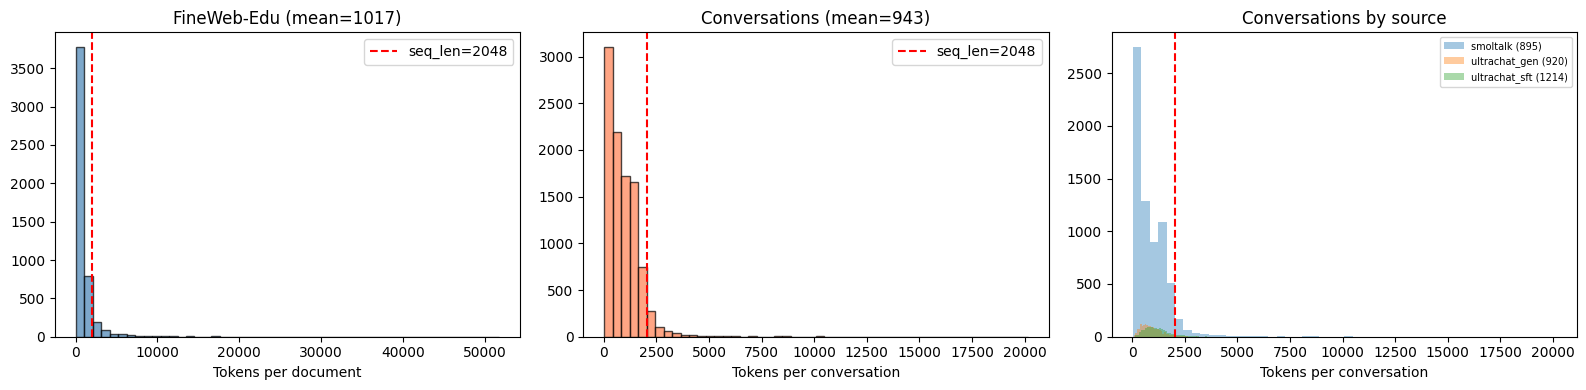

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# FineWeb
axes[0].hist(fw_arr, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(2048, color='red', linestyle='--', label='seq_len=2048')
axes[0].set_title(f'FineWeb-Edu (mean={fw_arr.mean():.0f})')
axes[0].set_xlabel('Tokens per document')
axes[0].legend()

# All conversations
axes[1].hist(conv_arr, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(2048, color='red', linestyle='--', label='seq_len=2048')
axes[1].set_title(f'Conversations (mean={conv_arr.mean():.0f})')
axes[1].set_xlabel('Tokens per conversation')
axes[1].legend()

# Per-source conversations
for src in sorted(by_source):
    axes[2].hist(by_source[src], bins=50, alpha=0.4, label=f'{src} ({np.mean(by_source[src]):.0f})')
axes[2].axvline(2048, color='red', linestyle='--')
axes[2].set_title('Conversations by source')
axes[2].set_xlabel('Tokens per conversation')
axes[2].legend(fontsize=7)

plt.tight_layout()
plt.show()

## 5. Packing efficiency analysis

With packed streaming, multiple conversations are concatenated into 2048-token chunks. Estimate how many packed sequences we get vs the old padding approach.

In [8]:
seq_len = 2048
total_conv = len(all_conv_rows)
mean_tokens = conv_arr.mean()
total_conv_tokens = total_conv * mean_tokens

# Old approach: 1 padded sequence per conversation
old_sequences = total_conv
old_useful_tokens = total_conv_tokens
old_total_tokens = old_sequences * seq_len
old_efficiency = old_useful_tokens / old_total_tokens

# New approach: pack conversations end-to-end, chunk at seq_len
new_sequences = total_conv_tokens / seq_len
new_efficiency = 1.0  # ~100% by construction (tiny remainder lost)

print('=== Packing Efficiency ===')
print(f'Total conversations: {total_conv:,}')
print(f'Mean tokens/conv: {mean_tokens:.0f}')
print(f'Total conversation tokens: {total_conv_tokens/1e9:.2f}B')
print()
print(f'OLD (padded to {seq_len}):')
print(f'  Sequences: {old_sequences:,.0f}')
print(f'  Useful tokens: {old_useful_tokens/1e9:.2f}B / {old_total_tokens/1e9:.2f}B')
print(f'  Efficiency: {old_efficiency:.1%}')
print()
print(f'NEW (packed):')
print(f'  Sequences: {new_sequences:,.0f}')
print(f'  Efficiency: ~100%')
print(f'  Speedup: {old_sequences/new_sequences:.1f}x fewer sequences for same data')

=== Packing Efficiency ===
Total conversations: 1,507,814
Mean tokens/conv: 943
Total conversation tokens: 1.42B

OLD (padded to 2048):
  Sequences: 1,507,814
  Useful tokens: 1.42B / 3.09B
  Efficiency: 46.0%

NEW (packed):
  Sequences: 693,905
  Efficiency: ~100%
  Speedup: 2.2x fewer sequences for same data


## 6. Test PackedStreamingDataset

In [9]:
from run_10_midtrain import PackedStreamingDataset
from pathlib import Path

fineweb_path = Path(fineweb_dir)
conv_path = Path(conv_dir)
fw_files = sorted(fineweb_path.glob('*.parquet'))
cv_files = sorted(conv_path.glob('*.parquet'))

In [10]:
# Test FineWeb text format
fw_ds = PackedStreamingDataset(
    fw_files[:1], tokenizer, seq_length=2048,
    max_sequences=5, data_format='text'
)

print('=== FineWeb (text format) ===')
for i, sample in enumerate(fw_ds):
    ids = sample['input_ids']
    labels = sample['labels']
    print(f'  seq {i}: input_ids={ids.shape}, labels={labels.shape}')
    # Verify shift: labels[i] == input_ids[i+1] for a packed stream
    # (except last position where label comes from next token in buffer)
    decoded = tokenizer.decode(ids[:50])
    print(f'    first 50 tokens: {decoded[:200]}')
    # Check for EOS boundaries
    eos_count = (ids == tokenizer.eos_token_id).sum().item()
    print(f'    EOS tokens in sequence: {eos_count}')

=== FineWeb (text format) ===
  seq 0: input_ids=torch.Size([2048]), labels=torch.Size([2048])
    first 50 tokens: Shipment & Transport-Sea, Air, Rail, Road, Pipeline
The mode of transportation is an important consideration when planning the shipment process. Besides the costs, the urgency of the shipment, the val
    EOS tokens in sequence: 1
  seq 1: input_ids=torch.Size([2048]), labels=torch.Size([2048])
    first 50 tokens:  wholly or partly out of State funds or dedicated to the use of the general public. (3) Nothing in this article shall prevent the State from making any special provision for women and children. (4) No
    EOS tokens in sequence: 2
  seq 2: input_ids=torch.Size([2048]), labels=torch.Size([2048])
    first 50 tokens: 
Human-centered design of robots can be very challenging, because once you’ve gotten a robot to a point where you’re ready for user testing, the kinds of major changes that you can easily implement ar
    EOS tokens in sequence: 0
  seq 3: input_ids=

In [11]:
# Test conversation format (all sources)
conv_ds = PackedStreamingDataset(
    cv_files[:1], tokenizer, seq_length=2048,
    max_sequences=5, data_format='conversation'
)

print('=== Conversation (all sources, packed) ===')
for i, sample in enumerate(conv_ds):
    ids = sample['input_ids']
    labels = sample['labels']
    bos_count = (ids == tokenizer.bos_token_id).sum().item()
    eos_count = (ids == tokenizer.eos_token_id).sum().item()
    user_count = (ids == tokenizer.convert_tokens_to_ids('<|user|>')).sum().item()
    asst_count = (ids == tokenizer.convert_tokens_to_ids('<|assistant|>')).sum().item()
    print(f'  seq {i}: shape={ids.shape}, BOS={bos_count}, EOS={eos_count}, <user>={user_count}, <asst>={asst_count}')
    decoded = tokenizer.decode(ids[:80])
    print(f'    first 80 tokens: {decoded[:300]}')

=== Conversation (all sources, packed) ===
  seq 0: shape=torch.Size([2048]), BOS=3, EOS=2, <user>=4, <asst>=4
    first 80 tokens: <|beginoftext|><|user|>A tailor cut 0.75 inch off a skirt and some inches off a pair of pants. The tailor cut 0.25 inch more off the skirt than the pants. How much did the tailor cut off the pants?<|assistant|>Let's denote the amount cut off the pants as x inches. According to the information given,
  seq 1: shape=torch.Size([2048]), BOS=4, EOS=4, <user>=7, <asst>=6
    first 80 tokens:  of the first corner. Defaults to 0."},"x2":{"type":"integer","description":"The x-coordinate of the opposite corner. Defaults to 1."},"y2":{"type":"integer","description":"The y-coordinate of the opposite corner. Defaults to 1."}}}}}]</tools>

The output MUST strictly adhere to the following format
  seq 2: shape=torch.Size([2048]), BOS=2, EOS=2, <user>=5, <asst>=4
    first 80 tokens: 
QScriptEngine engine;
QScriptValue myScriptValue = engine.newVariant(myVariant);
```

T

In [12]:
# Test conversation with source filter
for source in ['smoltalk', 'ultrachat_gen', 'ultrachat_sft']:
    ds = PackedStreamingDataset(
        cv_files[:1], tokenizer, seq_length=2048,
        max_sequences=3, data_format='conversation', source_filter=source
    )
    samples = list(ds)
    print(f'{source}: got {len(samples)} packed sequences')
    if samples:
        ids = samples[0]['input_ids']
        bos_count = (ids == tokenizer.bos_token_id).sum().item()
        print(f'  first seq: {bos_count} conversations packed, shape={ids.shape}')

smoltalk: got 3 packed sequences
  first seq: 3 conversations packed, shape=torch.Size([2048])
ultrachat_gen: got 3 packed sequences
  first seq: 2 conversations packed, shape=torch.Size([2048])
ultrachat_sft: got 3 packed sequences
  first seq: 3 conversations packed, shape=torch.Size([2048])


## 7. Verify packed format correctness

Check that packed sequences contain proper `[BOS...EOS, BOS...EOS]` boundaries and that the input/label shift is correct.

In [13]:
# Detailed verification on a single packed sequence
conv_ds = PackedStreamingDataset(
    cv_files[:1], tokenizer, seq_length=2048,
    max_sequences=1, data_format='conversation'
)
sample = next(iter(conv_ds))
ids = sample['input_ids']
labels = sample['labels']

# 1. Verify shift: labels should be ids shifted left by 1
# Both come from chunk[:-1] and chunk[1:] of the same buffer
print('=== Shift verification ===')
print(f'input_ids[0:5]:  {ids[:5].tolist()}')
print(f'labels[0:5]:     {labels[:5].tolist()}')
print(f'Expected labels = input shifted by 1: {ids[1:6].tolist()}')
# labels[i] should equal the token at position i+1 in the original chunk
# Since chunk = buffer[:seq_len+1], input_ids = chunk[:-1], labels = chunk[1:]
# So labels[i] = chunk[i+1] = input_ids[i+1] (for i < seq_len-1)
shift_matches = (labels[:-1] == ids[1:]).sum().item()
print(f'Shift matches: {shift_matches}/{len(ids)-1} ({shift_matches/(len(ids)-1)*100:.1f}%)')

# 2. Find conversation boundaries
bos_positions = (ids == tokenizer.bos_token_id).nonzero(as_tuple=True)[0].tolist()
eos_positions = (ids == tokenizer.eos_token_id).nonzero(as_tuple=True)[0].tolist()
print(f'\n=== Conversation boundaries ===')
print(f'BOS at positions: {bos_positions}')
print(f'EOS at positions: {eos_positions}')
print(f'Conversations in this chunk: ~{len(bos_positions)}')

# 3. Decode around first boundary
if len(eos_positions) >= 1:
    eos_pos = eos_positions[0]
    start = max(0, eos_pos - 3)
    end = min(len(ids), eos_pos + 5)
    print(f'\n=== Around first EOS (pos {eos_pos}) ===')
    for j in range(start, end):
        tok = tokenizer.decode([ids[j].item()])
        print(f'  [{j}] {ids[j].item():>6} = {tok!r}')

=== Shift verification ===
input_ids[0:5]:  [50257, 50259, 32, 35280, 2005]
labels[0:5]:     [50259, 32, 35280, 2005, 657]
Expected labels = input shifted by 1: [50259, 32, 35280, 2005, 657]
Shift matches: 2047/2047 (100.0%)

=== Conversation boundaries ===
BOS at positions: [0, 210, 1856]
EOS at positions: [209, 1855]
Conversations in this chunk: ~3

=== Around first EOS (pos 209) ===
  [206]    262 = ' the'
  [207]  12581 = ' pants'
  [208]     13 = '.'
  [209]  50256 = '<|endoftext|>'
  [210]  50257 = '<|beginoftext|>'
  [211]  50259 = '<|user|>'
  [212]     40 = 'I'
  [213]    765 = ' want'


## 8. Midtraining mix summary

In [14]:
# Estimate total tokens available per source
fw_total_docs = sum(pq.ParquetFile(os.path.join(fineweb_dir, f)).metadata.num_rows for f in fineweb_files)
fw_mean_tokens = fw_arr.mean()
fw_total_tokens = fw_total_docs * fw_mean_tokens

conv_by_source = Counter(r['source'] for r in all_conv_rows)
conv_mean_by_source = {src: np.mean(by_source[src]) for src in by_source}

print('=== Midtraining Data Budget ===')
print(f'FineWeb-Edu: {fw_total_docs:,} docs, ~{fw_total_tokens/1e9:.1f}B tokens')
for src in sorted(conv_by_source):
    count = conv_by_source[src]
    mean_t = conv_mean_by_source.get(src, mean_tokens)
    total_t = count * mean_t
    print(f'{src}: {count:,} convs, ~{total_t/1e9:.2f}B tokens')
print(f'\nTotal conversation tokens: ~{total_conv_tokens/1e9:.2f}B')
print(f'Total FineWeb tokens: ~{fw_total_tokens/1e9:.1f}B')

print('\n=== Configured mix ratios ===')
mix = {'fineweb': 0.30, 'smoltalk': 0.4844, 'ultrachat_gen': 0.119, 'ultrachat_sft': 0.0966}
for name, ratio in mix.items():
    print(f'  {name}: {ratio:.1%}')

=== Midtraining Data Budget ===
FineWeb-Edu: 90,990,592 docs, ~92.5B tokens
smoltalk: 1,043,917 convs, ~0.93B tokens
ultrachat_gen: 256,032 convs, ~0.24B tokens
ultrachat_sft: 207,865 convs, ~0.25B tokens

Total conversation tokens: ~1.42B
Total FineWeb tokens: ~92.5B

=== Configured mix ratios ===
  fineweb: 30.0%
  smoltalk: 48.4%
  ultrachat_gen: 11.9%
  ultrachat_sft: 9.7%
